Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Micro-Ultrasound Prostate Segmentation with MONAI

This tutorial demonstrates how to perform 2D/3D prostate segmentation using MONAI on the Micro-Ultrasound Prostate Segmentation Dataset.

The tutorial covers:
1. Custom dataset class for handling Micro-Ultrasound data with multiple annotation types
2. Data transforms for training and validation
3. UNet model setup for segmentation
4. Training loop with validation
5. Visualization of results
6. Model evaluation

The Micro-Ultrasound Prostate Segmentation Dataset can be downloaded from [Zenodo](https://zenodo.org/record/10475293).

**Target:** Prostate  
**Modality:** Micro-Ultrasound  
**Task:** Segmentation


In [1]:
%env BUILD_MONAI=1
!pip install -q "monai[all] @ git+https://github.com/Project-MONAI/MONAI.git"

env: BUILD_MONAI=1


In [1]:
!python -c "import monai" || pip install -q "monai[itk, nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import matplotlib.pyplot as plt

from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Spacingd,ScaleIntensityd, RandCropByPosNegLabeld, RandRotate90d, RandFlipd, Resized, Activations, AsDiscrete
from monai.data import DataLoader, decollate_batch
from torch.utils.data import Subset
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric

from monai.inferers import sliding_window_inference

import torch

In [3]:
ROOT_DIR = "./dataset_test"
os.makedirs(ROOT_DIR, exist_ok=True)
print(f"Dataset will be stored in: {os.path.abspath(ROOT_DIR)}")

Dataset will be stored in: /teamspace/studios/this_studio/dataset_test


## Dataset Setup

This tutorial uses MONAI's standard dataset classes instead of a custom dataset class. We'll:
1. Download the dataset using wget and unzip
2. Generate data lists manually
3. Use MONAI's `Dataset` or `CacheDataset` classes for loading

**Note:** The original custom dataset class is preserved below (commented out) for reference.


## Download Dataset

Download the Micro-Ultrasound Prostate Segmentation Dataset from Zenodo using wget and extract it using unzip.


In [5]:
import os
from pathlib import Path

# Dataset configuration
DATASET_URL = "https://zenodo.org/record/10475293/files/Micro_Ultrasound_Prostate_Segmentation_Dataset.zip"
ZIP_FILE_NAME = "Micro_Ultrasound_Prostate_Segmentation_Dataset.zip"
DATASET_FOLDER_NAME = "Micro_Ultrasound_Prostate_Segmentation_Dataset"

zip_path = Path(ROOT_DIR) / ZIP_FILE_NAME
dataset_folder = Path(ROOT_DIR) / DATASET_FOLDER_NAME

# Download dataset if not already present
if not dataset_folder.exists():
    if not zip_path.exists():
        print(f"Downloading dataset from {DATASET_URL}...")
        os.system(f"wget -O {zip_path} {DATASET_URL}")
        print("Download complete!")
    else:
        print(f"Zip file already exists: {zip_path}")
    
    # Extract the dataset
    print(f"Extracting dataset to {ROOT_DIR}...")
    os.system(f"unzip -q {zip_path} -d {ROOT_DIR}")
    print("Extraction complete!")
else:
    print(f"Dataset already extracted at: {dataset_folder}")

# Verify dataset folder exists
if not dataset_folder.exists():
    raise RuntimeError(f"Dataset folder missing: {dataset_folder}")
else:
    print(f"Dataset ready at: {dataset_folder}")


--2025-12-13 13:15:25--  https://zenodo.org/record/10475293/files/Micro_Ultrasound_Prostate_Segmentation_Dataset.zip
Resolving zenodo.org (zenodo.org)... 188.185.43.153, 137.138.52.235, 188.185.48.75, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.153|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/10475293/files/Micro_Ultrasound_Prostate_Segmentation_Dataset.zip [following]
--2025-12-13 13:15:26--  https://zenodo.org/records/10475293/files/Micro_Ultrasound_Prostate_Segmentation_Dataset.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 3570972743 (3.3G) [application/octet-stream]
Saving to: ‘dataset_test/Micro_Ultrasound_Prostate_Segmentation_Dataset.zip’

     0K .......... .......... .......... .......... ..........  0%  141K 6h50m
    50K .......... .......... .......... .......... ..........  0%  291K 5h5m
   100K .......... .......... .......... .......... ..........  

Download complete!
Extracting dataset to ./dataset_test...
Extraction complete!
Dataset ready at: dataset_test/Micro_Ultrasound_Prostate_Segmentation_Dataset


## Generate Data Lists

Create data lists that map image files to their corresponding annotation files. This function handles the mapping logic for different annotation types.


In [6]:
from pathlib import Path

# Annotation type mappings
ANNOTATION_MAP = {
    "expert": "expert_annotations",
    "non_expert": "non_expert_annotations",
    "master": "master_student_annotations",
    "medical": "medical_student_annotations",
    "clinician": "clinician_annotations",
}

FILE_PREFIX_MAP = {
    "expert": "expert_annotation",
    "non_expert": "non_expert_annotation",
    "master": "master_student_annotation",
    "medical": "medical_student_annotation",
    "clinician": "clinician_annotation",
}


def generate_data_list(root_dir, section, annotation_type="expert"):
    """
    Generate a list of dictionaries containing image and label file paths.
    
    Args:
        root_dir: Root directory containing the dataset
        section: Either "training" or "test"
        annotation_type: Type of annotation to use (default: "expert")
    
    Returns:
        List of dictionaries with "image" and "label" keys
    """
    root_dir = Path(root_dir)
    dataset_folder = root_dir / DATASET_FOLDER_NAME
    
    if annotation_type not in ANNOTATION_MAP:
        raise ValueError(f"Unsupported annotation_type: {annotation_type}")
    
    if section not in ["training", "test"]:
        raise ValueError("section must be 'training' or 'test'")
    
    # Map "training" to "train" folder name
    section_folder = "train" if section == "training" else "test"
    section_dir = dataset_folder / section_folder
    image_dir = section_dir / "micro_ultrasound_scans"
    label_dir = section_dir / ANNOTATION_MAP[annotation_type]
    
    if not image_dir.is_dir() or not label_dir.is_dir():
        raise RuntimeError(f"Missing required folders: {image_dir} or {label_dir}")
    
    # Find all image files (.nii.gz)
    image_files = sorted(f for f in image_dir.iterdir() if f.name.endswith(".nii.gz"))
    print(f"Found {len(image_files)} image files.")
    
    data_list = []
    label_prefix = FILE_PREFIX_MAP[annotation_type]
    
    for img in image_files:
        # Remove "microUS_" prefix to get the base filename
        suffix = img.name.replace("microUS_", "")
        label_name = f"{label_prefix}_{suffix}"
        label_path = label_dir / label_name
        
        if not label_path.exists():
            print(f"Warning: label missing for {img.name}, expected {label_name}")
            continue
        
        data_list.append({
            "image": str(img),
            "label": str(label_path),
        })
    
    if not data_list:
        raise RuntimeError("No subjects found. Check dataset structure.")
    
    print(f"Final paired subjects: {len(data_list)}")
    return data_list


## Create Datasets Using MONAI Standard Classes

Use MONAI's `CacheDataset` class to create training and validation datasets. This class handles data loading and caching efficiently.


In [7]:
from monai.data import CacheDataset

# Generate data list for training section
train_data_list = generate_data_list(
    root_dir=ROOT_DIR,
    section="training",
    annotation_type="expert"
)

# Split into training and validation (80/20 split)
train_size = int(0.8 * len(train_data_list))
val_size = len(train_data_list) - train_size
train_indices = list(range(train_size))
val_indices = list(range(train_size, len(train_data_list)))

# Create training and validation data lists
train_data = [train_data_list[i] for i in train_indices]
val_data = [train_data_list[i] for i in val_indices]

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")


Found 55 image files.
Final paired subjects: 55
Training samples: 44
Validation samples: 11


## Setup transforms for training and validation

Here we define transforms for:
- **Training**: Includes data augmentation (random crops, rotations, flips) to improve model generalization
- **Validation**: Only includes necessary preprocessing (load, ensure channel first, spacing, intensity scaling)


In [8]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        Resized(keys=["image", "label"], spatial_size=(256, 256, 48)),
        ScaleIntensityd(keys="image", minv=0.0, maxv=1.0),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        Resized(keys=["image", "label"], spatial_size=(256, 256, 48)),
        ScaleIntensityd(keys="image", minv=0.0, maxv=1.0),
    ]
)


## Create Training and Validation Datasets

Create MONAI `CacheDataset` instances for training and validation using the data lists we generated. The datasets will apply the transforms we defined earlier.


In [9]:
# Create training dataset using CacheDataset
train_ds = CacheDataset(
    data=train_data,
    transform=train_transforms,
    cache_rate=0.0,
    num_workers=0,
)

# Create validation dataset using CacheDataset
val_ds_subset = CacheDataset(
    data=val_data,
    transform=val_transforms,
    cache_rate=0.0,
    num_workers=0,
)

print(f"Training samples: {len(train_ds)}")
print(f"Validation samples: {len(val_ds_subset)}")

Training samples: 44
Validation samples: 11


## Check data shape and visualize a sample


Image shape: torch.Size([1, 1, 256, 256, 48]), Label shape: torch.Size([1, 1, 256, 256, 48])
Detected 3D data


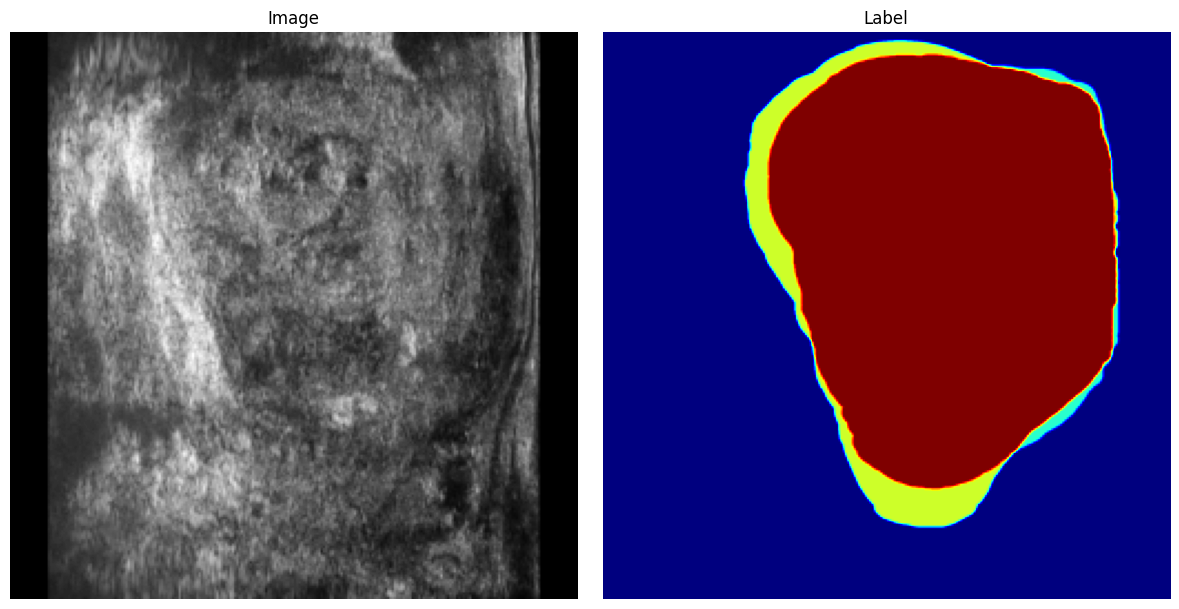

In [10]:
from monai.config import print_config
from monai.utils import set_determinism, first

# Check a sample from training data to determine data shape
check_loader = DataLoader(train_ds, batch_size=1, num_workers=0)
check_data = first(check_loader)
image, label = check_data["image"], check_data["label"]
print(f"Image shape: {image.shape}, Label shape: {label.shape}")

# Store spatial dimensions for later use
spatial_dims = 3 if len(image.shape) == 5 else 2
print(f"Detected {spatial_dims}D data")

# Visualize a sample slice
if len(image.shape) == 5:  # [B, C, H, W, D]
    slice_idx = image.shape[-1] // 2
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image[0, 0, :, :, slice_idx].cpu().numpy(), cmap="gray")
    axes[0].set_title("Image")
    axes[0].axis("off")
    axes[1].imshow(label[0, 0, :, :, slice_idx].cpu().numpy(), cmap="jet")
    axes[1].set_title("Label")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()
elif len(image.shape) == 4:  # [B, C, H, W]
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image[0, 0].cpu().numpy(), cmap="gray")
    axes[0].set_title("Image")
    axes[0].axis("off")
    axes[1].imshow(label[0, 0].cpu().numpy(), cmap="jet")
    axes[1].set_title("Label")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()


## Create Model, Loss, and Optimizer

We'll use a 3D UNet model for segmentation with Dice Loss and Adam optimizer.


In [11]:
spatial_dims = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Using {spatial_dims}D UNet")

# Create UNet model
model = UNet(
    spatial_dims=spatial_dims,
    in_channels=1,
    out_channels=2,  # Background + foreground
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
    num_res_units=2,
    norm=("batch", {"eps": 1e-5, "momentum": 0.1}),
).to(device)

# Loss function
loss_function = DiceLoss(to_onehot_y=True, softmax=True)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

# Metric
dice_metric = DiceMetric(include_background=False, reduction="mean")

# Post-processing transforms
post_pred = Compose([Activations(softmax=True), AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")


Using device: cuda
Using 3D UNet
Model parameters: 1,187,921


## Training loop

Execute the training process with validation at regular intervals.


In [12]:
max_epochs = 5 # Using a smaller number of epochs for the sake of the tutorial
val_interval = 5
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

# Create data loaders for training
train_loader = DataLoader(
    train_ds,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    pin_memory=torch.cuda.is_available(),
)
val_loader = DataLoader(val_ds_subset, batch_size=1, num_workers=0)

print("Starting training...")
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"Epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        if step % 10 == 0:
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"Epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = val_data["image"].to(device), val_data["label"].to(device)
                # Use sliding window inference for larger images
                roi_size = (96, 96, 96) if spatial_dims == 3 else (96, 96)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(ROOT_DIR, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"Current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nBest mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}"
            )

print(f"Training completed! Best metric: {best_metric:.4f} at epoch: {best_metric_epoch}")


Starting training...
----------
Epoch 1/5


10/22, train_loss: 0.4961
20/22, train_loss: 0.4846
Epoch 1 average loss: 0.4994
----------
Epoch 2/5
10/22, train_loss: 0.4788
20/22, train_loss: 0.4588
Epoch 2 average loss: 0.4764
----------
Epoch 3/5
10/22, train_loss: 0.4473
20/22, train_loss: 0.4422
Epoch 3 average loss: 0.4565
----------
Epoch 4/5
10/22, train_loss: 0.4513
20/22, train_loss: 0.4232
Epoch 4 average loss: 0.4328
----------
Epoch 5/5
10/22, train_loss: 0.3919
20/22, train_loss: 0.3849
Epoch 5 average loss: 0.4050


Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)


saved new best metric model
Current epoch: 5 current mean dice: 0.6383
Best mean dice: 0.6383 at epoch: 5
Training completed! Best metric: 0.6383 at epoch: 5


## Plot training loss and validation metric


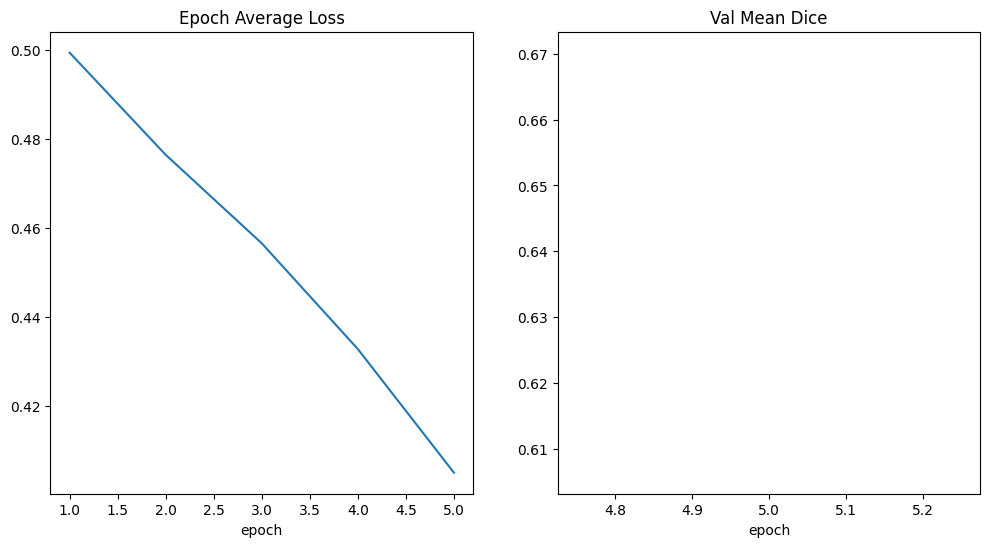

In [13]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()


## Visualize best model predictions

Load the best model and visualize predictions on validation samples.


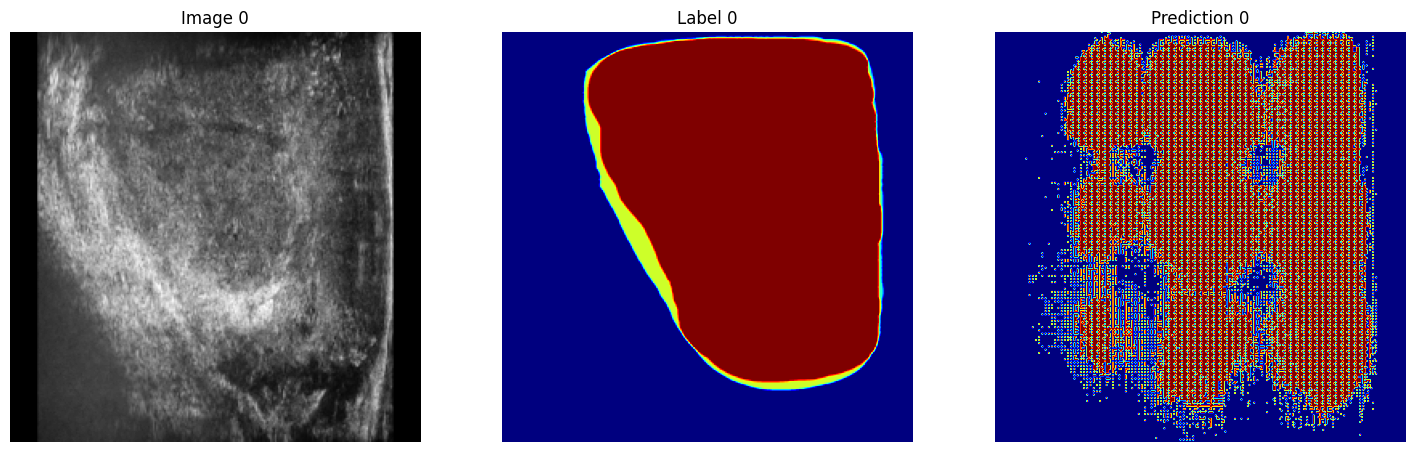

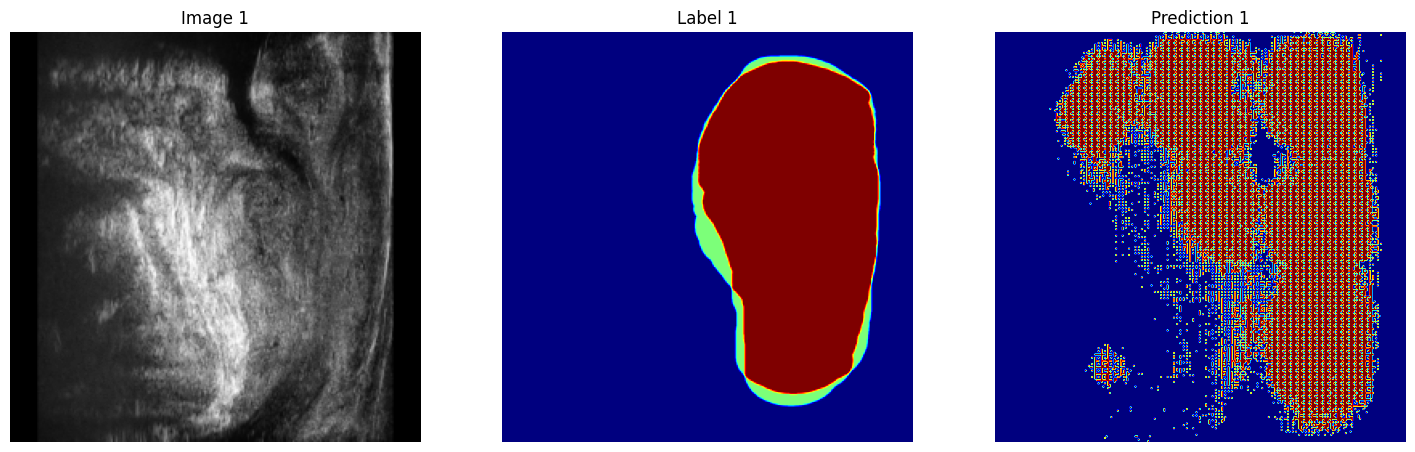

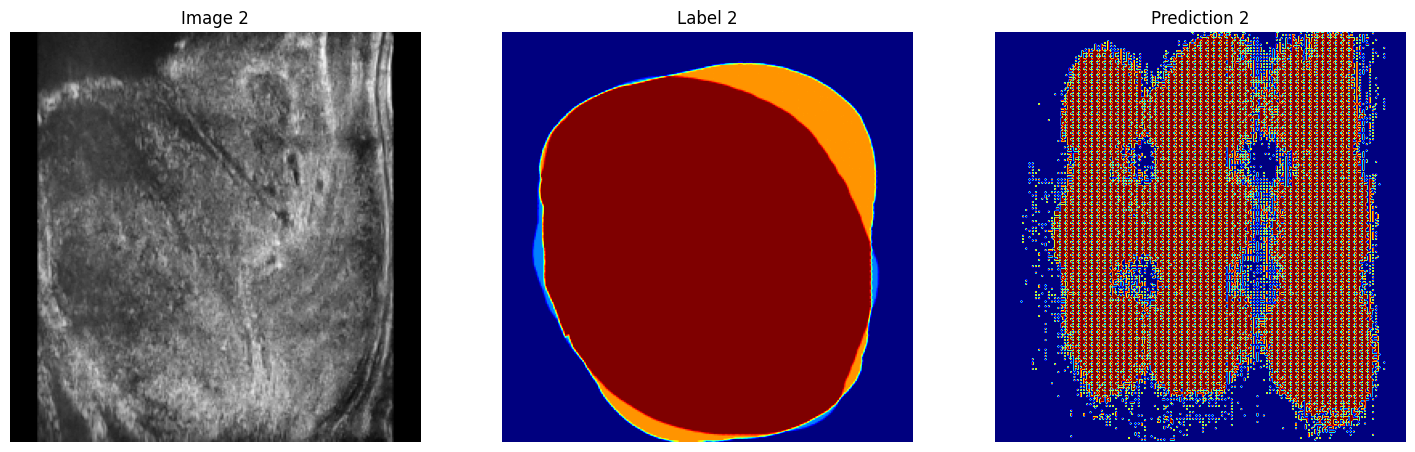

In [14]:
model.load_state_dict(torch.load(os.path.join(ROOT_DIR, "best_metric_model.pth"), weights_only=True))
model.eval()
val_loader = DataLoader(val_ds_subset, batch_size=1, num_workers=0)
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        val_inputs = val_data["image"].to(device)
        roi_size = (96, 96, 96) if spatial_dims == 3 else (96, 96)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)

        # Get the slice for visualization
        if spatial_dims == 3:
            slice_idx = val_inputs.shape[-1] // 2
            img_slice = val_inputs[0, 0, :, :, slice_idx].cpu()
            label_slice = val_data["label"][0, 0, :, :, slice_idx].cpu()
            pred_slice = torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_idx]
        else:
            img_slice = val_inputs[0, 0].cpu()
            label_slice = val_data["label"][0, 0].cpu()
            pred_slice = torch.argmax(val_outputs, dim=1).detach().cpu()[0]

        # Plot
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"Image {i}")
        plt.imshow(img_slice, cmap="gray")
        plt.axis("off")
        plt.subplot(1, 3, 2)
        plt.title(f"Label {i}")
        plt.imshow(label_slice, cmap="jet")
        plt.axis("off")
        plt.subplot(1, 3, 3)
        plt.title(f"Prediction {i}")
        plt.imshow(pred_slice, cmap="jet")
        plt.axis("off")
        plt.show()

        if i == 2:  # Show first 3 samples
            break


## Evaluation on test set

Evaluate the model on the test set to get final performance metrics.


In [15]:
# Generate test data list
test_data_list = generate_data_list(
    root_dir=ROOT_DIR,
    section="test",
    annotation_type="expert"
)

# Create test dataset using CacheDataset
test_ds = CacheDataset(
    data=test_data_list,
    transform=val_transforms,
    cache_rate=1.0,
    num_workers=0,
)

test_loader = DataLoader(test_ds, batch_size=1, num_workers=0)

# Evaluate on test set
model.eval()
test_dice_metric = DiceMetric(include_background=False, reduction="mean")
with torch.no_grad():
    for test_data in test_loader:
        test_inputs, test_labels = test_data["image"].to(device), test_data["label"].to(device)
        roi_size = (96, 96, 96) if spatial_dims == 3 else (96, 96)
        sw_batch_size = 4
        test_outputs = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)
        test_outputs = [post_pred(i) for i in decollate_batch(test_outputs)]
        test_labels = [post_label(i) for i in decollate_batch(test_labels)]
        test_dice_metric(y_pred=test_outputs, y=test_labels)

test_metric = test_dice_metric.aggregate().item()
test_dice_metric.reset()

print(f"Test set mean Dice score: {test_metric:.4f}")


Found 20 image files.
Final paired subjects: 20


Loading dataset: 100%|██████████| 20/20 [04:34<00:00, 13.74s/it]


Test set mean Dice score: 0.6433
